<center><img src='https://drive.google.com/uc?export=view&id=12CrUdXDAiltLBT26sG7HZ_HciIhvGyT8'></center>

<!--[image.png](attachment:image.png) -->

# Wstęp do uczenia maszynowego - Notebook 4, version for students

**Author: Marcin Sydow and Jacek Sroka**

In this notebook we start working with supervised learning.

Our first working example will be the K-nn ("K nearest neighbours") classifier, perhaps the simplest model for classification.

### K-nn classifier (reminder)

K-nn classifies a new case $x$ by assigning the majority label among the $k$ data points in the train set that are closest to $x$ in the attribute space. K-nn classifier is a bit special, since during "training" it actually does not build any model, but then directly uses train data when classifying a new case.

## Contents

1. First, we do train/validation/test data split.
2. Next, we experiment with the k-nn ("K nearest neighbours") classifier.
We will study how the k hyper-parameter of this classifier affects its bias-variance tradeoff by observing the changing shapes of the class boundaries in the attribute space as the value of k changes.
3. We do similar experiments with the Naive Bayes classifier, another basic model.
4. We will also use a separate *validation set* to tune the $k$ hyperparameter to achieve the best performance on the test set.
5. We will use some standard evaluation metrics such as *accuracy, precision, recall, f-measure* to evaluate the models as well as the *confusion matrix* to quantify the errors made by the model.
6. We will also check whether data preprocessing (normalisation) can help to improve the model performance on the K-nn example.
7. We will also experiment with K-nn regressor variant as well.

## Module Imports ##

In [54]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set() # for easy heatmap visualisation


## Loading data
There are numerous ways to get data into the notebook.

For example, [sklearn.datasets](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.datasets) module contains many useful toy datasets.

In [55]:
import sklearn.datasets

One of the easy ways to get some dataset to work on is to use `load_NNNN()` method to load the dataset of name NNNN. This method returns an object of type `sklearn.utils.Bunch`, which has several attributes, among others:
* `data`
* `target`

which are of numpy `ndarray` type, containing the attributes and the decision attribute, respectively.

### Exercise 1 ###
Load some datasets using this method (e.g. "iris", "wine", "breast-cancer", "digits"), and see the type of the object returned by the `load_NNNN()` method as well as the types of its `data` and `target` attributyes (use `type` method).

In [56]:
data_i = sklearn.datasets.load_iris()
print(f" data type: {type(data_i.data)} target type: {type(data_i.target)}")

X = data_i.data
Y = data_i.target

 data type: <class 'numpy.ndarray'> target type: <class 'numpy.ndarray'>


## Train-test split
One should avoid testing the model on the data on which it will be train. The data should be split randomly into train and test sets.

### Question 2 ###
Can you exaplain why do the split and why it should be random?



```
One should split the data to avoid overfitting the model. The randomization assures that any specificity at which the elements where placed in the data.
```



### Stratified data split ###
The data split (in classification) is *stratified* if it approximately preserves the distribution of the class labels in all parts of the splitted dataset. Stratification is generally recommended.

See: [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html#sklearn.model_selection.train_test_split) function and, in particular, how to stratify the split.

In [57]:
from sklearn.model_selection import train_test_split

### Exercise 3 ###
Split the dataset into train `(xtrain, ytrain)` and test `(xtest, ytest)` subsets. Use the `train_test_split` method. Set the size of the test set to 20% of the data. Use stratification.

NOTE: there is no single "right" rule for the proportion of train/test data. Generaly, the more data, the better for model training or testing. It is possible to study the performance of the model as the function of the proportion of the split, but we omit such method for simplicity.

In [58]:
xtrain,xtest,ytrain,ytest = train_test_split(X, Y, stratify=Y, random_state=44, test_size=0.2)

print(f"{xtrain.shape} : {xtest.shape} : {ytrain.shape} : {ytest.shape}")


(120, 4) : (30, 4) : (120,) : (30,)


## Hyperparameter tuning with validation set
If the model to be used has any *hyperparameters*, i.e. parameters that are not set automatically during the training, it is good to split out from the train set a separate *validation set* to test the performance of the model for different hyperparameter settings before the optimal model will be ultimately tested on the test set.

The model is trained multiple times (for different hyperparameter settings) on the train set and the performance is measured on the validation set. Finally, the model with the best value of the hyperparameter is used and ultimately tested on the separate test set.

NOTE: In this notebook we will use validation set for hyperparameter tuning, however there are other methods for hyperparameter tuning, e.g. *cross-validation* method that is more sophisticated and it will be studied in another module.

### Question 4 ###
Why to use separate validation set when evaluating the tuned hyperparameter? Isn't the test set sufficient for this?


NO because the hyper parameters can change and thus overfitting is more probable. And we only want the most optimal ones.


### Exercise 5 ###
Split the initial train set into partial train set `(xptrain, yptrain)` and validation set `(xval, yval)` using the `train_test_split` method on the initial train set. Let validation set be 25% of the size of the initial train set.

In [59]:
xptrain,xval,yptrain,yval = train_test_split(xtrain, ytrain, stratify=ytrain, random_state=44, test_size=0.25)


print(f"{xptrain.shape} : {xval.shape} : {yptrain.shape} : {yval.shape}")

(90, 4) : (30, 4) : (90,) : (30,)


## Studying the variance and overfitting of the k-nn model (visually) ##
Now we will use the k-nn classifier on this data and visualize (in 2D, so we can only ose two dimmensions of the data) the class borders.

There are many ways of reducing the dimensionality of the data. For now we simply extract the first two dimensions of the dataset being aware that this is a very crude operation.

NOTE: there exist more sophisticated algorithms for dimensionality reduction, e.g. PCA, T-SNE, etc., that will be studied in a separate notebook.

In [60]:
data2 = xtrain[:,:2]
data2test = xtest[:,:2]
print(data2)

[[6.  2.7]
 [5.1 3.8]
 [5.4 3. ]
 [6.9 3.1]
 [5.5 2.4]
 [4.8 3. ]
 [6.7 3.1]
 [5.5 4.2]
 [5.4 3.9]
 [6.3 3.4]
 [4.4 3. ]
 [6.7 3. ]
 [6.3 2.7]
 [6.1 3. ]
 [5.7 2.8]
 [6.  2.2]
 [6.7 3.3]
 [5.6 2.8]
 [6.5 3. ]
 [5.  2. ]
 [5.8 2.6]
 [4.5 2.3]
 [6.6 3. ]
 [6.5 3.2]
 [6.8 2.8]
 [7.3 2.9]
 [5.3 3.7]
 [4.8 3.4]
 [6.1 3. ]
 [6.2 3.4]
 [6.4 2.9]
 [5.7 4.4]
 [6.3 2.8]
 [7.7 3.8]
 [5.2 2.7]
 [6.3 2.9]
 [6.4 3.2]
 [6.4 2.8]
 [5.8 4. ]
 [5.1 3.5]
 [4.9 2.4]
 [4.9 2.5]
 [4.8 3.4]
 [6.2 2.2]
 [5.1 3.8]
 [5.  3.5]
 [5.  3. ]
 [7.9 3.8]
 [5.5 3.5]
 [5.4 3.7]
 [5.1 3.4]
 [6.2 2.9]
 [6.5 3. ]
 [5.6 3. ]
 [6.2 2.8]
 [5.  3.4]
 [6.1 2.8]
 [6.5 2.8]
 [5.6 2.5]
 [5.5 2.3]
 [4.9 3. ]
 [6.4 2.8]
 [7.2 3.6]
 [6.5 3. ]
 [6.7 3. ]
 [5.7 2.6]
 [6.  3. ]
 [6.3 2.3]
 [5.7 3.8]
 [4.8 3.1]
 [5.1 3.5]
 [4.7 3.2]
 [7.  3.2]
 [5.8 2.7]
 [6.1 2.6]
 [4.3 3. ]
 [5.2 3.4]
 [5.5 2.4]
 [7.1 3. ]
 [5.8 2.7]
 [6.  3.4]
 [6.3 2.5]
 [6.3 2.5]
 [7.2 3.2]
 [5.9 3. ]
 [6.3 3.3]
 [6.9 3.2]
 [4.9 3.1]
 [4.7 3.2]
 [6.8 3.2]
 [5.7 2.8]

## Train the k-nn classifier ##
When the data is prepared, training a classifier in the scikit-learn module is extremely simple, it usually consists of 2 straight-forward steps (for any classifier):
1. creating the classifier with a constructor (providing necessary arguments specified in the documentation),
1. training it: using the `fit` method.

In the case of the K-nn classifier the constructor is [KNeighboursClassifier](https://scikit-learn.org/stable/modules/neighbors.html#nearest-neighbors-classification). It takes the value of $k$ as the parameter. The [fit](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier.fit) method usually takes 2 arguments: train data (here: `xtrain` or `data2`) and labels (here: `ytrain`).


In [61]:
from sklearn.neighbors import KNeighborsClassifier

### Exercise 6 ###
Create and fit a Knn model for $k = 5$ on the `data2` dataset.

In [62]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(data2, ytrain)


KNeighborsClassifier()

## Visualisation of the class borders ##
Let's write some function that will visualise the class borders in the attribute space, for example:

Note: Alternatively it is possible to try [DecisionBoundaryDisplay](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.DecisionBoundaryDisplay.html#sklearn.inspection.DecisionBoundaryDisplay.from_estimator).

In [63]:
plt.figure(figsize = (20,20))

# visualise the borders of classes
def visualiseModel2D(classifier, data, num = 50, alpha = 0.2, ax = None):
    xmin = np.min(data[:,0])
    xmax = np.max(data[:,0])
    ymin = np.min(data[:,1])
    ymax = np.max(data[:,1])
    xx, yy = np.meshgrid(np.linspace(xmin, xmax, num = num), np.linspace(ymin, ymax, num = num))
    xxx = xx.reshape(num * num)
    yyy = yy.reshape(num * num)
    X2 = np.c_[xxx, yyy]
    sns.scatterplot(x = xxx,y = yyy, c = classifier.predict(X2),
                    alpha = alpha, cmap = 'gnuplot', marker='s', legend = False, ax = ax)


<Figure size 2000x2000 with 0 Axes>

### Exercise 7 ###
Visualise the class borders with the above function. Try lower and higher values of $k$ to see how the class borders change.


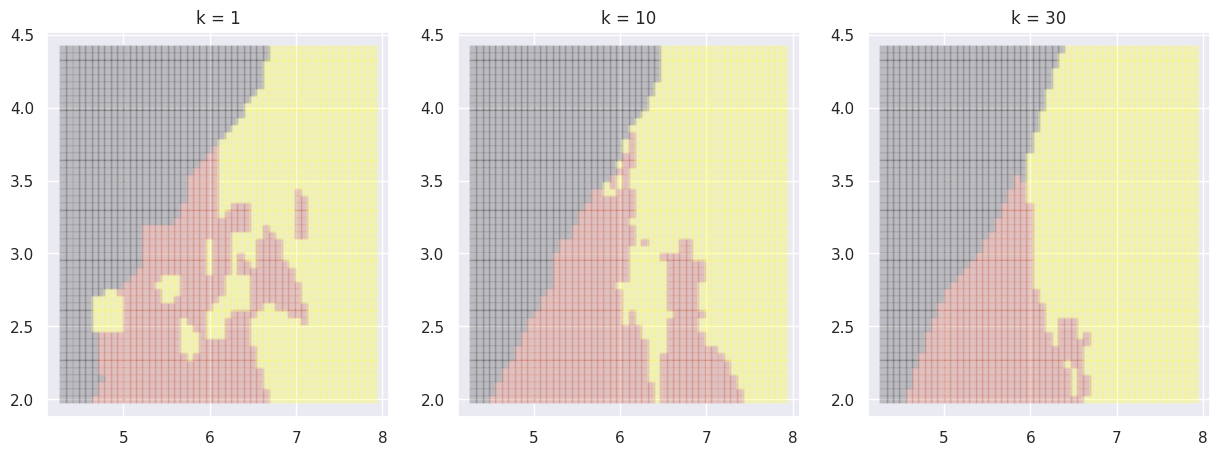

In [64]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, k in enumerate([1, 10, 30]):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(data2, ytrain)

    ax = axes[i]
    ax.set_title(f"k = {k}")
    visualiseModel2D(knn, data2, ax=ax)

plt.show()

### Exercise 8 ###
Add the train data points to the plot. Hint: use [sns.scatterplot](https://seaborn.pydata.org/generated/seaborn.scatterplot.html).

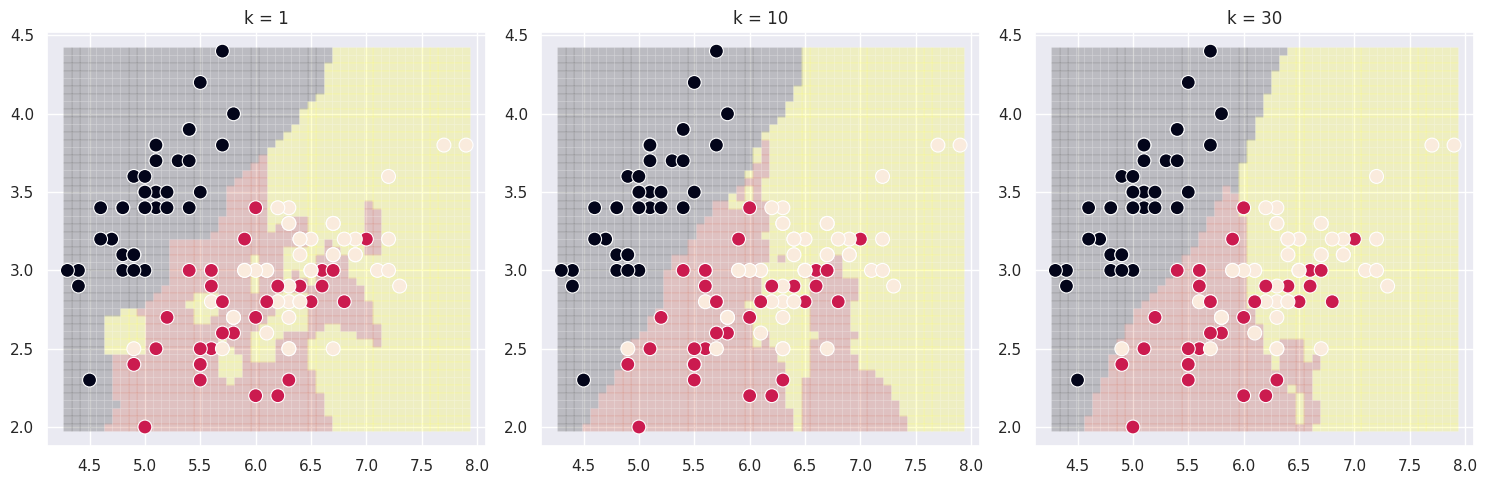

In [65]:
import seaborn as sns


fig, axes = plt.subplots(1, 3, figsize=(15, 5))

k_values = [1, 10, 30]

for i, k in enumerate(k_values):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(data2, ytrain)

    ax = axes[i]
    ax.set_title(f"k = {k}")

    visualiseModel2D(knn, data2, ax=ax)

    sns.scatterplot(x=data2[:, 0], y=data2[:, 1],c=ytrain, edgecolor="white", ax=ax, s=100, marker="o")

plt.tight_layout()
plt.show()



### Question 9 ###
Does increasing $k$ also increases the variance ("complexity") of the k-nn model? Do you know what the bias vs variance tradeoff is?


### Overfitting of the k-nn model

On our plot, overfitting can be visualised as the phenomenon that some test data points go to the wrong classes even if the model is seemingly well fitted for the train data.

### Exercise 10 ###
Now show on the graph the test points. You can optionally try lower and higher values of $k$ to better see overfiting and undefitting.

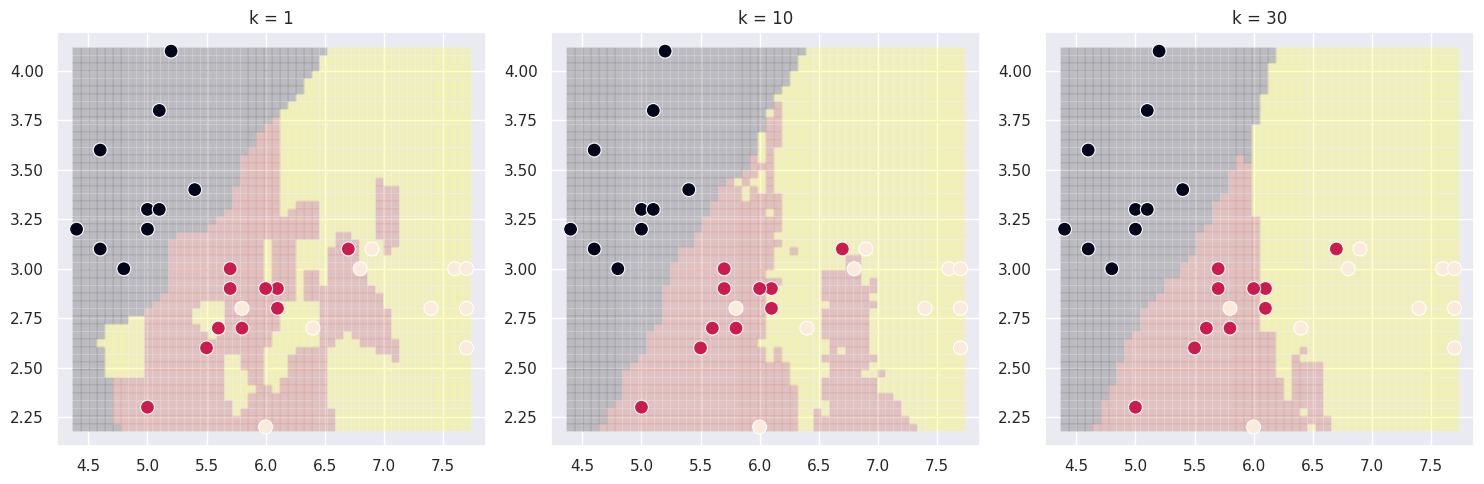

In [66]:
import seaborn as sns

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

k_values = [1, 10, 30]

for i, k in enumerate(k_values):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(data2, ytrain)

    ax = axes[i]
    ax.set_title(f"k = {k}")

    visualiseModel2D(knn, data2test, ax=ax)

    sns.scatterplot(x=data2test[:, 0], y=data2test[:, 1],c=ytest, edgecolor="white", ax=ax, s=100, marker="o")

plt.tight_layout()
plt.show()


## Naive Bayes classifier ##
Let us repeat the above exercises with another classifier: Naive Bayes Classifier. There are many variants thereof. We will use [GaussianNB](https://scikit-learn.org/stable/modules/naive_bayes.html#gaussian-naive-bayes).

In [67]:
from sklearn.naive_bayes import GaussianNB

### Exercise 11 ###
Repeat previous exercises with the Naive Bayes classifier: create and fit the model, visualise class borders, add test points to the plot.

Note: Naive Bayes model does not have any hyperparameters analogous to $k$ in the K-nn.

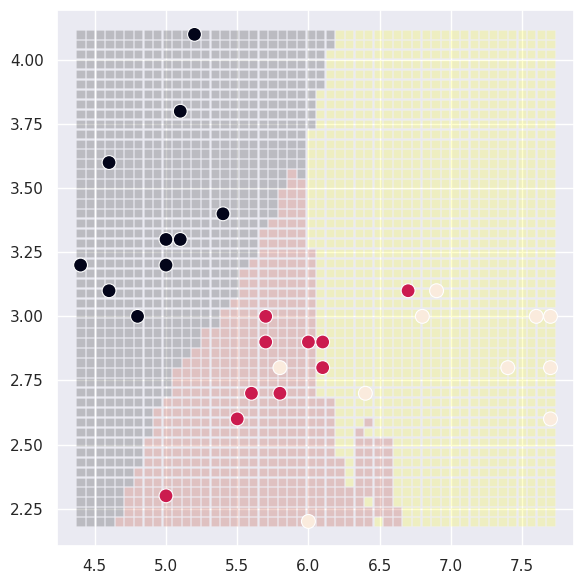

In [68]:
fig, ax = plt.subplots(figsize=(6, 6))

gnb = GaussianNB()
gnb.fit(data2, ytrain)


visualiseModel2D(knn, data2test, ax=ax)

sns.scatterplot(x=data2test[:, 0], y=data2test[:, 1],c=ytest, edgecolor="white", ax=ax, s=100, marker="o")

plt.tight_layout()
plt.show()


## Evaluation of the model performance

Now, let's return to the K-nn model and practice hyperparameter tuning.


### Exercise 12
Fit the k-nn model for (extreme value of) $k = 1$ on the training set and then evaluate it on the:
1. train set,
2. validation set,
3. test set.

For evaluation use the `score` function of the model. It computes the prediction accuracy.

Observe the differences in performance of the model on the three subsets: usually the performance on the test or validation set are lower than on the train set. It can be viewed as another form of overfitting.

In [69]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(xptrain, yptrain)
print(f"{knn.score(xptrain,yptrain)} {knn.score(xval, yval)} {knn.score(xtest, ytest)}")

1.0 0.9666666666666667 0.9666666666666667


### Question 13
How do can you explain differences between the results on train/validation/test above? How does they depend on the value of $k$? Test lower and higher values of $k$.

### Exercise 14
There are several ways of evaluating the model in scikit learn, for example the [f1_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html) function is a harmonic mean of precision and recall. Other methods will be shown in other modules. For now print the f1 score for predictions from our K-nn classfier.


In [70]:
from sklearn.metrics import f1_score
predVal = knn.predict(xval)
f1_score(yval, predVal, average='macro')

0.9665831244778613

## Hyperparameter tuning using validation dataset
Now we will use the f1 score on the validation set to find the best value of the hyperparameter $k$.

### Exercise 15
Prepare a graph of f1 score as a function of $k$ ranging from 1 to 80.
Identify and print the value of $k$ that maksimizes f1 score on the validation set.

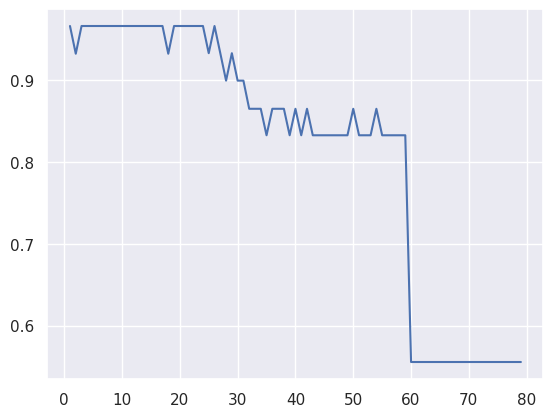

 best k for training: 1


In [71]:
values = []
best_val = 0;
best_k = 1;
for i in range(1,80):
  knn = KNeighborsClassifier(n_neighbors=i)
  knn.fit(xptrain, yptrain)
  predVal = knn.predict(xval)
  val = f1_score(yval, predVal, average='macro')
  values.append(val)
  if val > best_val:
    best_val = val
    best_k = i

#print(values)

plt.plot(range(1,80), values)
plt.show()
print(f" best k for training: {best_k}")

## Training the optimal model
When the optimal model and values of hyperparameters are found one can train the model on the re-merged train set, i.e. partial train + validation set, with the optimal hyperparameter setting.

### Question 16
Why to train the model again on the re-merged train and validation set?

### Exercise 17
Now, train the best model on the re-merged train set, i.e. `xtrain` that is obtained from merging `xptrain` and `xval` into one train set. Evaluate it using the f1 score.

In [72]:
knn = KNeighborsClassifier(n_neighbors=8)
knn.fit(xtrain, ytrain)
predVal = knn.predict(xval)
score = f1_score(yval, predVal, average='macro')
print(score)

0.9665831244778613


## The role of data preprocessing on the performance

Performance of the model can be usually improved by preprocessing the data. One of the simplest ways, that usually works for K-nn in particular, is to normalize (or scale) the numeric data to have similar ranges, means and/or standard deviations. There are many ways of normalizing the data, including: min-max scaling, normalizing (subtracting the mean and dividing by the standard deviation of each attribute) or exponential scaling, etc. (see https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing )


### Exericise 18
Summarize the statistics of the attributes: construct `DataFrame` out of the `xtrain` set and use its `describe` method. Do all the attributes have the same ranges of values? Can it (negatively) influence the performance of the model?


In [73]:
type(xtrain)

df = pd.DataFrame(xtrain)
df.describe()

,0,1,2,3
count,120.000000,120.000000,120.000000,120.000000
mean,5.825833,3.072500,3.739167,1.203333
std,0.781562,0.445324,1.732987,0.760245
min,4.300000,2.000000,1.100000,0.100000
25%,5.100000,2.800000,1.575000,0.300000
50%,5.800000,3.000000,4.400000,1.300000
75%,6.400000,3.400000,5.100000,1.800000
max,7.900000,4.400000,6.700000,2.500000


### Question 19
Why normalization (or standardization) of attributes can improve performance of K-nn or other models?

### Warning: Do not forget that when train data is scaled, the validation and test set have to be scaled in exactly the same way for the model to work correctly.


## Constructing a Pipeline
[Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html#sklearn.pipeline.Pipeline) is a very useful tool in scikit-learn that has applications in any situation when multiple steps are to be applied to the data in a repeatable way. Here, we illustrate pipeline on a "toy" example that consists only of 2 steps: scaling and fitting, however it has much wider applications and pipelines can contain many more steps.

### Example: scaling and using Pipeline
Normalize the data with [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html). Fit the model on the scaled data, evaluate it and compare the score with the previous results (on non-scaled data).

In [74]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
pipe = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier(n_neighbors = 4))])
pipe.fit(xptrain, yptrain)
#Pipeline(steps=[('scaler', StandardScaler()), ('svc', SVC())])
pipe.score(xtest, ytest)

0.9666666666666667

### Exercise 20
Repeat hyperparameter tuning for the K-nn model on the normalized data plotting the functional dependence of f1 score on the value of $k$. You can use Pipeline as in the above example.



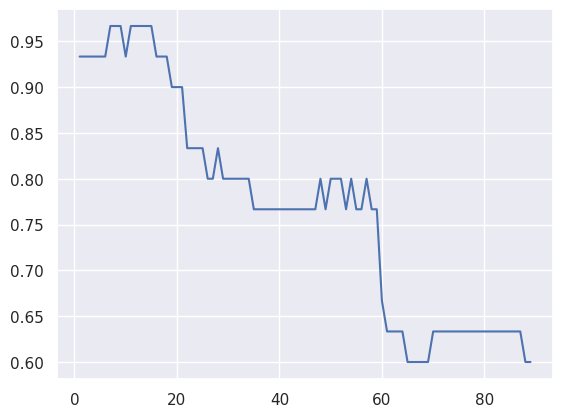

best k 7


In [75]:
scores = []
best_score = 0
best_k = 1
for k in range(1, 90):
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('knn', KNeighborsClassifier(n_neighbors=k))
    ])

    pipe.fit(xptrain, yptrain)
    score = pipe.score(xval, yval)
    scores.append(score)
    if score > best_score:
      best_score = score
      best_k = k
plt.plot(range(1, 90), scores)
plt.show()
print(f"best k {best_k}")

### Exercise 21
Train the K-nn model with the newly selected optimal $k$ value on the re-merged data set. Compare the performance of the final model with the previous ones.

In [76]:
pipe = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier(n_neighbors = 20))])
pipe.fit(xtrain, ytrain)
pipe.score(xtest, ytest)

0.9666666666666667

<center><img src='https://drive.google.com/uc?id=1_utx_ZGclmCwNttSe40kYA6VHzNocdET' height="60">

AI TECH - Akademia Innowacyjnych Zastosowań Technologii Cyfrowych. Program Operacyjny Polska Cyfrowa na lata 2014-2020
<hr>

<img src='https://drive.google.com/uc?id=1BXZ0u3562N_MqCLcekI-Ens77Kk4LpPm'>


Projekt współfinansowany ze środków Unii Europejskiej w ramach Europejskiego Funduszu Rozwoju Regionalnego
Program Operacyjny Polska Cyfrowa na lata 2014-2020,
Oś Priorytetowa nr 3 "Cyfrowe kompetencje społeczeństwa" Działanie  nr 3.2 "Innowacyjne rozwiązania na rzecz aktywizacji cyfrowej".   
Tytuł projektu:  „Akademia Innowacyjnych Zastosowań Technologii Cyfrowych (AI Tech)”
    </center>